<center><h1>Finetune Gemma 3N 4B Vision for LateX math equations</h1></center>

# Introduction

This Notebook introduces:
- Finetune of Gemma 3N 4B model for LateX math equations. It is derived from: [Gemma 3N 4B Vision Finetuning](https://www.kaggle.com/code/danielhanchen/gemma-3n-4b-vision-finetuning)
- Save the model to Kaggle Models: https://www.kaggle.com/models/gpreda/gemma3n-latex-math-eq/
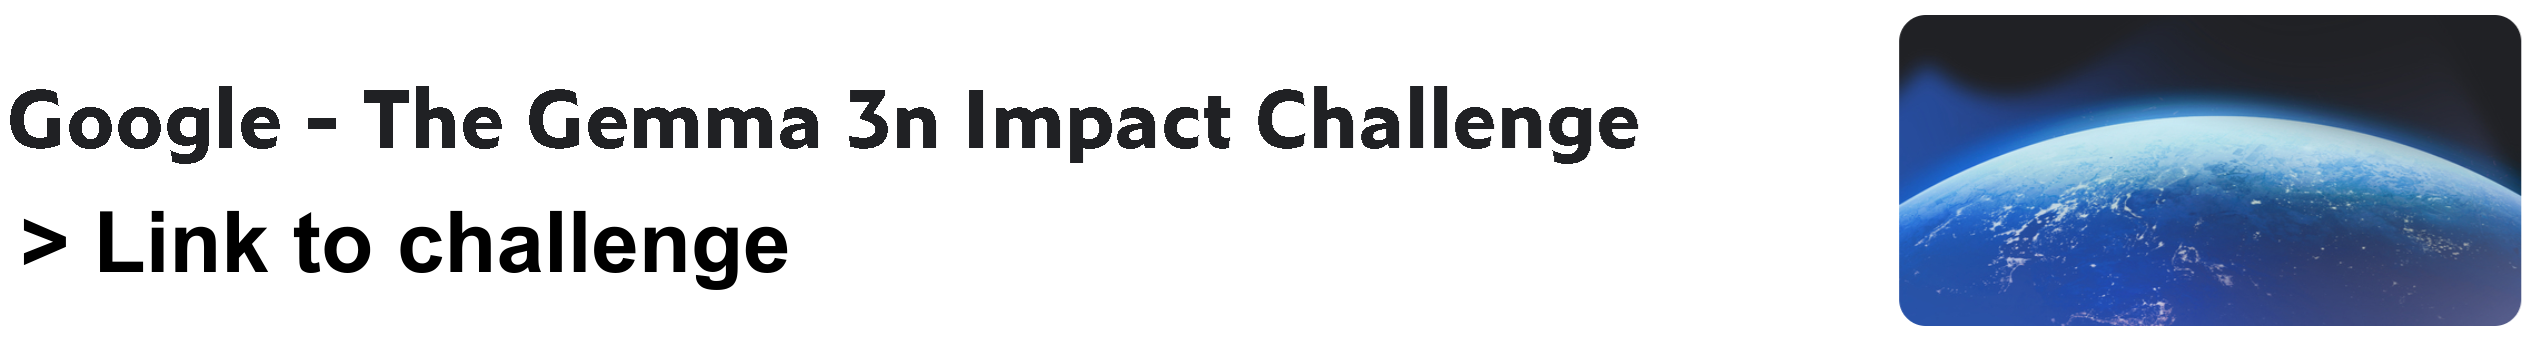
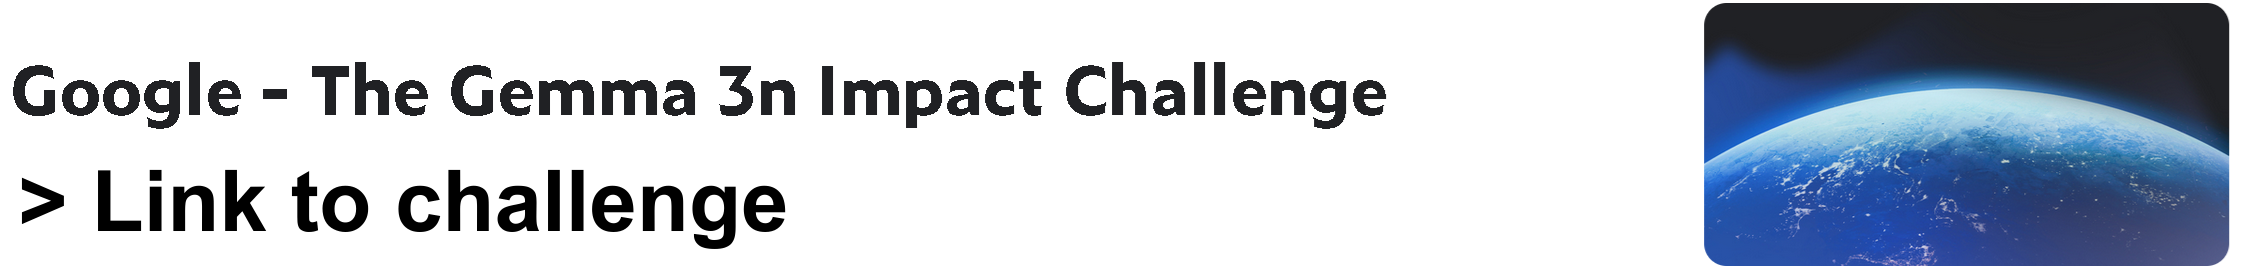

# Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

In [2]:
%%capture
# Install latest transformers for Gemma 3N
!pip install --no-deps --upgrade transformers # Only for Gemma 3N
!pip install --no-deps --upgrade timm # Only for Gemma 3N

# About Unsloth

`FastVisionModel` supports loading nearly any model now! This includes Vision, Text and Audio models!

In [3]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3n-E4B-it-unsloth-bnb-4bit",
    "unsloth/gemma-3n-E2B-it-unsloth-bnb-4bit",
    # Pretrained models
    "unsloth/gemma-3n-E4B-unsloth-bnb-4bit",
    "unsloth/gemma-3n-E2B-unsloth-bnb-4bit",

    # Other Gemma 3 quants
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, processor = FastVisionModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E4B", # Or "unsloth/gemma-3n-E2B-it"
    dtype = None, # None for auto detection
    max_seq_length = 1024, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-03 12:59:12.682055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754225952.900225      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754225952.959735      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.1: Fast Gemma3N patching. Transformers: 4.54.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/769 [00:00<?, ?B/s]


# Vision finetuning for Gemma 3N

In this notebook, our goal is to transcribe LaTeX maths equations by finetuning the base / pretrained model for Gemma 3N.

We now add LoRA adapters for parameter efficient fine-tuning, allowing us to train only 1% of all model parameters efficiently.


In [4]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 32,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 32,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,              # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


<a name="Data"></a>
# Data preparation
We'll use a sampled dataset of handwritten math formulas. The objective is to convert these images into a computer-readable format—specifically LaTeX—so they can be rendered. This is particularly useful for complex expressions.

You can access the dataset [here](https://huggingface.co/datasets/unsloth/LaTeX_OCR). The full dataset is [here](https://huggingface.co/datasets/linxy/LaTeX_OCR).

In [5]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

Let's take an overview of the dataset. We'll examine the second image and its corresponding caption.

In [6]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

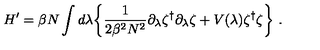

In [7]:
dataset[2]["image"]

In [8]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

We can also render LaTeX directly in the browser!

In [9]:
from IPython.display import display, Math, Latex

latex = dataset[3]["text"]
display(Math(latex))

<IPython.core.display.Math object>

To format the dataset, all vision fine-tuning tasks should follow this format:

```python
[
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": sample["image"]},
        ],
    },
    {
        "role": "assistant", 
         "content": [
             {"type": "text", "text": sample["text"]}
         ]
    },
]
```

In [10]:
instruction = "Write the LaTeX representation for this image."

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {
            "role": "assistant", 
             "content": [
                 {"type": "text", "text": sample["text"]}
             ]
        },
    ]
    return {"messages": conversation}
pass

Let's convert the dataset into the "correct" format for finetuning:

In [11]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [12]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

The sample we saw before (2) is formated like:

In [13]:
converted_dataset[2]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=320x50>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'}]}]}

Lets take the Gemma 3n instruction chat template and use it in our base model

In [14]:
from unsloth import get_chat_template

processor = get_chat_template(
    processor,
    "gemma-3n"
)

Before fine-tuning, let us evaluate the base model's performance. We do not expect strong results, as it has not encountered this chat template before.

In [15]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[2]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

  number="1" 
  count_sym=1 
  count_sym_arg=1 
  count_sym_arg_arg=1 
  count_sym_arg_arg_arg=1 
  count_sym_arg_arg_arg_arg=1 
  count_sym_arg_arg_arg_arg_arg=1 
  count_sym_arg_arg_arg_arg_arg_arg=1 
  count_sym_arg_arg_arg_arg_arg_arg_arg=1 
  


You can see it's absolutely terrible! It doesn't follow instructions at all

<a name="Train"></a>
# Train the model

Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [16]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        max_grad_norm = 0.3,            # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        max_steps = 60,
        #num_train_epochs = 2,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    )
)

Unsloth: Model does not have a default image size - using 512


In [17]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
12.592 GB of memory reserved.


# Finetuning Gemma 3N 4B for vision task

We will finetune Gemma 3N 4B for an image to text generation task.

In [18]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 76,840,960 of 7,926,819,152 (0.97% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,6.334900
2,6.125200
3,6.278100
4,5.644600
5,5.870200
6,6.793600
7,3.960300
8,3.518300
9,3.324500
10,3.722400


In [19]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

870.824 seconds used for training.
14.51 minutes used for training.
Peak reserved memory = 12.592 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 85.422 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Inference"></a>
# Inference

Let's run the model! You can modify the instruction and input—just leave the output blank.

We'll use the best hyperparameters for inference on Gemma: `top_p=0.95`, `top_k=64`, and `temperature=1.0`.

In [20]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataset[10]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)

inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

[ [ B _ { n } ^ { + } , b _ { 2 } ^ { + } ] = n B _ { n } ^ { + } , \quad [ [ B _ { n } ^ { - } , b _ { 2 } ^ { + } ] , b _ { 2 } ^ { - } ] = n B _ { n } ^ { - } .
<eos>


let's check the image as well:

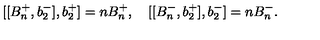

In [21]:
dataset[10]["image"]

<a name="Save"></a>
# Saving models

To save the final model as LoRA adapters, use Hugging Face’s `push_to_hub` for online saving, or `save_pretrained` for local storage.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [22]:
model.save_pretrained("lora_model")  # Local saving
processor.save_pretrained("lora_model")

['lora_model/processor_config.json']

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [23]:
if False:
    from unsloth import FastVisionModel

    model, processor = FastVisionModel.from_pretrained(
        model_name="lora_model",  # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit=True,  # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model)  # Enable for inference!

FastVisionModel.for_inference(model)  # Enable for inference!

sample = dataset[1]
image = sample["image"].convert("RGB")
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": sample["text"],
            },
            {
                "type": "image",
            },
        ],
    },
]
input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor.tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

D _ { \mu } ^ { \alpha \beta } \bar { A } _ { \mu } ^ { \alpha \beta } = 0 ,
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{equation}
\end{


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [24]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if True: model.save_pretrained_merged("lora_unsloth_finetune", processor,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", processor, token = "PUT_HERE")

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  25%|██▌       | 1/4 [00:19<00:58, 19.56s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  50%|█████     | 2/4 [00:59<01:03, 31.72s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  75%|███████▌  | 3/4 [01:46<00:38, 38.50s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [02:10<00:00, 32.60s/it]


## Publish the model using KaggleHub

Initialize the Kaggle username and key from User Secrets.

In [25]:
import kagglehub
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["KAGGLE_USERNAME"] = user_secrets.get_secret("kaggle_username")
os.environ["KAGGLE_KEY"] = user_secrets.get_secret("kaggle_key")

Define the URI for the model to publish

In [26]:
kaggle_username = os.environ["KAGGLE_USERNAME"]

kaggle_uri = f"{kaggle_username}/gemma3n-latex-math-eq/transformers/gemma3n_4b_latex_math_eq"
kagglehub.model_upload(kaggle_uri, "lora_unsloth_finetune", 'Apache 2.0')

Uploading Model https://www.kaggle.com/models/gpreda/gemma3n-latex-math-eq/transformers/gemma3n_4b_latex_math_eq ...
Starting upload for file lora_unsloth_finetune/processor_config.json


Uploading: 100%|██████████| 98.0/98.0 [00:00<00:00, 389B/s]

Upload successful: lora_unsloth_finetune/processor_config.json (98B)
Starting upload for file lora_unsloth_finetune/model.safetensors.index.json



Uploading: 100%|██████████| 171k/171k [00:00<00:00, 980kB/s]

Upload successful: lora_unsloth_finetune/model.safetensors.index.json (167KB)
Starting upload for file lora_unsloth_finetune/model-00001-of-00004.safetensors



Uploading: 100%|██████████| 3.08G/3.08G [00:31<00:00, 98.3MB/s]

Upload successful: lora_unsloth_finetune/model-00001-of-00004.safetensors (3GB)
Starting upload for file lora_unsloth_finetune/tokenizer.model



Uploading: 100%|██████████| 4.70M/4.70M [00:00<00:00, 18.2MB/s]

Upload successful: lora_unsloth_finetune/tokenizer.model (4MB)
Starting upload for file lora_unsloth_finetune/chat_template.jinja



Uploading: 100%|██████████| 1.63k/1.63k [00:00<00:00, 8.43kB/s]

Upload successful: lora_unsloth_finetune/chat_template.jinja (2KB)
Starting upload for file lora_unsloth_finetune/preprocessor_config.json



Uploading: 100%|██████████| 1.09k/1.09k [00:00<00:00, 6.24kB/s]

Upload successful: lora_unsloth_finetune/preprocessor_config.json (1KB)
Starting upload for file lora_unsloth_finetune/special_tokens_map.json



Uploading: 100%|██████████| 769/769 [00:00<00:00, 4.27kB/s]

Upload successful: lora_unsloth_finetune/special_tokens_map.json (769B)
Starting upload for file lora_unsloth_finetune/model-00003-of-00004.safetensors



Uploading: 100%|██████████| 4.99G/4.99G [00:35<00:00, 142MB/s]

Upload successful: lora_unsloth_finetune/model-00003-of-00004.safetensors (5GB)
Starting upload for file lora_unsloth_finetune/generation_config.json



Uploading: 100%|██████████| 191/191 [00:00<00:00, 1.01kB/s]

Upload successful: lora_unsloth_finetune/generation_config.json (191B)
Starting upload for file lora_unsloth_finetune/model-00004-of-00004.safetensors



Uploading: 100%|██████████| 2.66G/2.66G [00:19<00:00, 136MB/s]

Upload successful: lora_unsloth_finetune/model-00004-of-00004.safetensors (2GB)
Starting upload for file lora_unsloth_finetune/config.json



Uploading: 100%|██████████| 5.71k/5.71k [00:00<00:00, 27.4kB/s]

Upload successful: lora_unsloth_finetune/config.json (6KB)
Starting upload for file lora_unsloth_finetune/tokenizer.json



Uploading: 100%|██████████| 33.4M/33.4M [00:00<00:00, 82.6MB/s]

Upload successful: lora_unsloth_finetune/tokenizer.json (32MB)
Starting upload for file lora_unsloth_finetune/tokenizer_config.json



Uploading: 100%|██████████| 1.20M/1.20M [00:00<00:00, 6.70MB/s]

Upload successful: lora_unsloth_finetune/tokenizer_config.json (1MB)
Starting upload for file lora_unsloth_finetune/model-00002-of-00004.safetensors



Uploading: 100%|██████████| 4.97G/4.97G [00:49<00:00, 101MB/s]

Upload successful: lora_unsloth_finetune/model-00002-of-00004.safetensors (5GB)


Your model instance version has been created.
Files are being processed...
See at: https://www.kaggle.com/models/gpreda/gemma3n-latex-math-eq/transformers/gemma3n_4b_latex_math_eq


# Final remarks

From the original notebook authored by Unsloth, I modified it to save the model as a Kaggle Model.
